In [3]:
import sys
# print(sys.path)
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [87]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2

from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from imutils import paths


In [88]:
print(tf.__version__)

2.6.0


## Data Processing

In [89]:
def showVideo(path_to_file):
    clean_video = cv2.VideoCapture(path_to_file)

    if clean_video.isOpened() == False:
        print("Error opening video stream or file")

    while clean_video.isOpened():
        ret, frame = clean_video.read()
        if ret:
            cv2.imshow('Frame', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break
    cv2.destroyAllWindows()


In [90]:
def getImagesFromVideo(path_to_file, k=0):
    clean_video = cv2.VideoCapture(path_to_file)
    ret, frame = clean_video.read()
    count = 0
    while ret:
        if k == 1:
            cv2.imwrite("dataset/anomaly_images/image_anomaly_{}.jpg".format(count), frame)
        else: 
            cv2.imwrite("dataset/images/image_{}.jpg".format(count), frame)
        ret, frame = clean_video.read()
        count += 1
    print("Done reading {} frames from file {}".format(count, path_to_file))

In [262]:
def getData(path_to_file, image_size):
    imagePaths = list (paths.list_images(path_to_file))
    data = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        # print(image.shape)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (image_size, image_size))
        data.append(image)
    data = np.array(data).astype('float32') / 255.
    print("Done creating data for file {}".format(path_to_file))
    k = 0
    if k == 1:
        print(data.shape)
        cv2.imshow("data", data[0])
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return data

In [288]:
path_video_clean_data = '/home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleExperiment/clean_output.avi'
path_video_anomaly_data = '/home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleTestExperiment/anomaly_output.avi'

# showVideo(path_video_anomaly_data)

getImagesFromVideo(path_video_clean_data)
getImagesFromVideo(path_video_anomaly_data, k = 1)


path_clean_images = 'dataset/images'
path_anomalous_images = 'dataset/anomaly_images'
image_size = 56
data = getData(path_clean_images, image_size)
data_anomaly = getData(path_anomalous_images, image_size)


Done reading 221 frames from file /home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleExperiment/clean_output.avi
Done reading 161 frames from file /home/adeye/AD-EYE_Core/AD-EYE/Experiments/SimpleTestExperiment/anomaly_output.avi
Done creating data for file dataset/images
Done creating data for file dataset/anomaly_images


## Autoencoder

In [303]:
class AnomalyDetector(Model):
    def __init__(self, image_size, latentDim, hidden_layer_1, hidden_layer_2, channels):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (image_size, image_size, channels)),
            tf.keras.layers.Conv2D(hidden_layer_1, (3, 3), activation = 'relu', padding = 'same', strides = 2), 
            tf.keras.layers.Conv2D(hidden_layer_2, (3, 3), activation = 'relu', padding = 'same', strides = 2), 
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(latentDim, activation = 'relu'), 
        ])

        layer_shape = self.encoder.layers[-3].output_shape

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latentDim, )), 
            tf.keras.layers.Dense(layer_shape[1] * layer_shape[2] * layer_shape[3], activation = 'relu'), 
            tf.keras.layers.Reshape((layer_shape[1], layer_shape[2], layer_shape[3])), 
            tf.keras.layers.Conv2DTranspose(hidden_layer_2, kernel_size=3, activation = 'relu', padding = 'same', strides = 2), 
            tf.keras.layers.Conv2DTranspose(hidden_layer_1, kernel_size=3, activation = 'relu', padding = 'same', strides = 2),
            tf.keras.layers.Conv2DTranspose(channels, 3, padding = 'same', activation = 'relu'),
            # tf.keras.layers.Conv2D(channels, (3, 3), activation = 'relu', padding = 'same')
        ]) 

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




In [304]:
def splitDataAutoencoder(data):
    train_data, test_data = train_test_split(data, test_size = 0.2, random_state=42)
    train_data = tf.cast(train_data, tf.float32)
    test_data = tf.cast(test_data, tf.float32)
    ## add line if channels ! = 3, perform this, otherwise, skip it
    # train_data = train_data[..., tf.newaxis]
    # test_data = test_data[..., tf.newaxis]

    print(train_data.shape)
    return train_data, test_data

    

In [305]:
def trainModel(model, epochs, batch_size, optimizer, loss, metrics):
    model.compile(
        optimizer = optimizer, 
        loss=loss, 
        metrics = metrics,
        )
    history = model.fit(
        normal_train_data, normal_train_data,
        epochs = epochs, 
        batch_size = batch_size, 
        validation_data = (normal_test_data, normal_test_data), 
        shuffle = True
        )
    # plt.plot(history.history["loss"], label = "Training Loss")
    # plt.plot(history.history["val_loss"], label = "Validation Loss")
    # plt.legend()
    # plt.show()

    print(model.encoder.summary())
    print(model.decoder.summary())


In [306]:
def evaluateLosses(data):
    reconstruction = autoencoder.predict(data)
    train_loss = tf.keras.losses.mae(reconstruction, data)

    train_loss_image = []
    for i in range(len(train_loss)):
        loss_image = np.sum(train_loss[i]) / 255
        train_loss_image.append(loss_image)
    # print(len(train_loss_image))

    plt.hist(train_loss_image, bins=50)
    plt.xlabel("Train loss")
    plt.ylabel("No of examples")
    plt.show()
    return train_loss_image


In [307]:
def plotDifferences(test_data, n):
    encoded_data = autoencoder.encoder(test_data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(tf.squeeze(test_data[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        bx = plt.subplot(2, n, i + n + 1)
        plt.imshow(tf.squeeze(decoded_data[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

In [308]:

normal_train_data, normal_test_data = splitDataAutoencoder(data)
anomalous_train_data, anomalous_test_data = splitDataAutoencoder(data_anomaly)

latentDim = 32
hidden_layer_1 = 128
hidden_layer_2 = 64
channels = data.shape[-1]
autoencoder = AnomalyDetector(image_size=image_size, latentDim=latentDim, hidden_layer_1 = hidden_layer_1, hidden_layer_2 = hidden_layer_2, channels=channels)

trainModel(autoencoder, epochs=10, batch_size=32, optimizer='adam', loss = 'mae', metrics = ['mse'])

(176, 56, 56, 3)
(128, 56, 56, 3)
Epoch 1/10
6/6 [==============================] - 5s 642ms/step - loss: 0.4500 - mse: 0.2451 - val_loss: 0.2389 - val_mse: 0.0861
Epoch 2/10
6/6 [==============================] - 2s 391ms/step - loss: 0.1787 - mse: 0.0522 - val_loss: 0.1606 - val_mse: 0.0463
Epoch 3/10
6/6 [==============================] - 3s 564ms/step - loss: 0.1453 - mse: 0.0340 - val_loss: 0.1296 - val_mse: 0.0285
Epoch 4/10
6/6 [==============================] - 3s 455ms/step - loss: 0.1249 - mse: 0.0253 - val_loss: 0.1201 - val_mse: 0.0244
Epoch 5/10
6/6 [==============================] - 3s 506ms/step - loss: 0.1177 - mse: 0.0235 - val_loss: 0.1139 - val_mse: 0.0236
Epoch 6/10
6/6 [==============================] - 3s 515ms/step - loss: 0.1126 - mse: 0.0228 - val_loss: 0.1116 - val_mse: 0.0211
Epoch 7/10
6/6 [==============================] - 3s 467ms/step - loss: 0.1119 - mse: 0.0213 - val_loss: 0.1102 - val_mse: 0.0206
Epoch 8/10
6/6 [==============================] - 3s 453

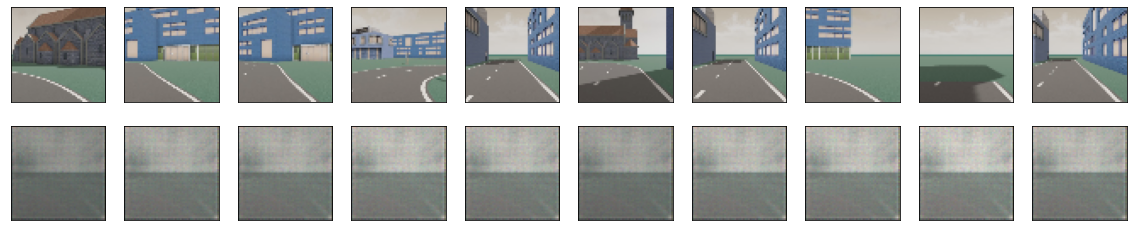

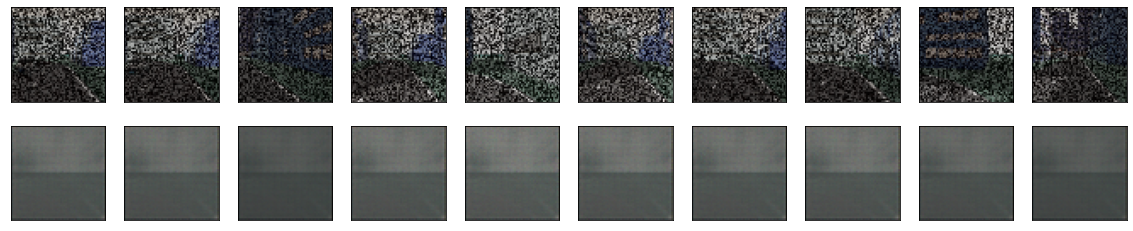

In [310]:
plotDifferences(normal_test_data, 10)
plotDifferences(anomalous_test_data, 10)

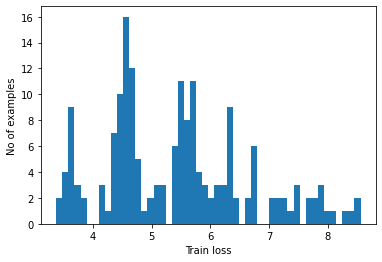

6.6432780764302946


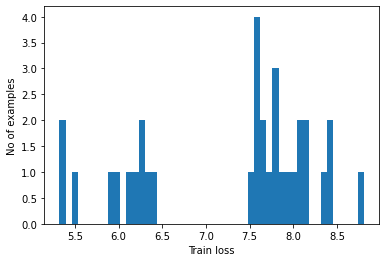

In [272]:
train_loss_image = evaluateLosses(normal_train_data)
threshold = np.mean(train_loss_image) + np.std(train_loss_image)
print(threshold)
test_loss_image = evaluateLosses(anomalous_test_data)

## Supervised Learning

In [10]:
X = np.concatenate((data, data_anomaly), axis = 0)
y = np.concatenate((np.zeros((len(data))), np.ones((len(data_anomaly)))), axis = 0)

In [11]:
print(data.shape)

(221, 128, 128, 3)


In [12]:
print(X.shape)

(382, 128, 128, 3)


In [13]:
X_train, X_aux, y_train, y_aux = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, shuffle=True, stratify=y_aux, test_size=0.1, random_state = 42)

In [14]:
print(X_train.shape)

(267, 128, 128, 3)


In [13]:
def augmentImages(image, flip = False, rotation = False):
    if flip == True:
        data_augmentation = tf.keras.layers.experimental.preprocessing.RandomFlip()
        return data_augmentation(image)
    elif rotation == True:
        data_augmentation = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
        return data_augmentation(image)

augmented_data_flip = augmentImages(X_train, flip = True)
augmented_data_rotation = augmentImages(X_train, rotation = True)
X_train_augmented = np.concatenate((X_train, augmented_data_flip, augmented_data_rotation), axis = 0)
y_train = np.concatenate((np.zeros((len(data))), np.ones((len(data_anomaly)))), axis = 0) 

2022-04-01 13:30:36.954636: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 13:30:36.956101: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
print(X_train.shape)
print(augmented_data_flip.shape)
print(augmented_data_rotation.shape)
print(X_train_augmented.shape)

(267, 128, 128, 3)
(267, 128, 128, 3)
(267, 128, 128, 3)
(801, 128, 128, 3)


In [22]:
cv2.imshow("augmented_data_flip", augmented_data_flip[-2].numpy())
# cv2.imshow("augmented_data_rotation", augmented_data_rotation[-1].numpy())
cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x56535bc19300) is not the object's thread (0x56535cf365e0).
Cannot move to target thread (0x56535bc19300)

QObject::moveToThread: Current thread (0x56535bc19300) is not the object's thread (0x56535cf365e0).
Cannot move to target thread (0x56535bc19300)

QObject::moveToThread: Current thread (0x56535bc19300) is not the object's thread (0x56535cf365e0).
Cannot move to target thread (0x56535bc19300)

QObject::moveToThread: Current thread (0x56535bc19300) is not the object's thread (0x56535cf365e0).
Cannot move to target thread (0x56535bc19300)

QObject::moveToThread: Current thread (0x56535bc19300) is not the object's thread (0x56535cf365e0).
Cannot move to target thread (0x56535bc19300)

QObject::moveToThread: Current thread (0x56535bc19300) is not the object's thread (0x56535cf365e0).
Cannot move to target thread (0x56535bc19300)

QObject::moveToThread: Current thread (0x56535bc19300) is not the object's thread (0x56535cf365e0).
Cannot move to tar

In [70]:
supervised_model = tf.keras.Sequential([
    # tf.keras.layers.experimental.preprocessing.RandomFlip(),
    # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.Flatten(input_shape = (image_size, image_size, 3)), 
    tf.keras.layers.Dense(64, activation = 'relu'), 
    tf.keras.layers.Dense(32, activation = 'relu'),
    # tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])



In [81]:
supervised_model = tf.keras.Sequential([
    # tf.leras.layers.Input(), 
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3)),
    tf.keras.layers.Conv2D(64, 3, padding='same',strides = 2, activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(), 
    tf.keras.layers.Conv2D(32, 3, padding='same',strides = 2, activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(),     
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')


])

In [82]:
supervised_model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics = ['accuracy']
)
history_sup = supervised_model.fit(
    X_train, y_train, 
    epochs = 10, 
    batch_size = 32, 
    shuffle = True, 
    # random_seed = 42, 
    validation_data = (X_val, y_val),     
)


Epoch 1/10
9/9 [==============================] - 5s 444ms/step - loss: 0.6110 - accuracy: 0.5693 - val_loss: 0.3912 - val_accuracy: 0.9612
Epoch 2/10
9/9 [==============================] - 4s 496ms/step - loss: 0.2738 - accuracy: 0.9326 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 4s 376ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 1.7446e-04 - val_accuracy: 1.0000
Epoch 4/10
9/9 [==============================] - 5s 560ms/step - loss: 3.2140e-04 - accuracy: 1.0000 - val_loss: 2.4583e-04 - val_accuracy: 1.0000
Epoch 5/10
9/9 [==============================] - 4s 461ms/step - loss: 7.1843e-05 - accuracy: 1.0000 - val_loss: 7.0514e-06 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 2s 270ms/step - loss: 7.0126e-06 - accuracy: 1.0000 - val_loss: 7.0800e-07 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 3s 393ms/step - loss: 6.7095e-06 - accuracy: 1.0000 - val_loss: 3.4082e-07 - val_a

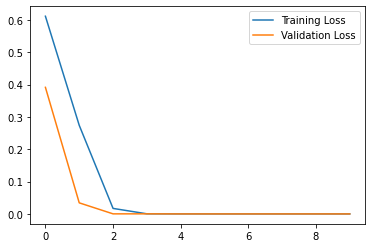

In [83]:
plt.plot(history_sup.history["loss"], label = "Training Loss")
plt.plot(history_sup.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

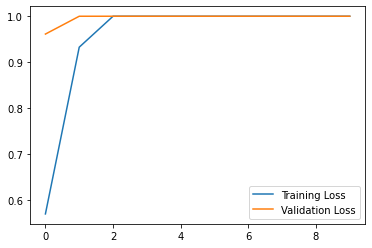

In [84]:
plt.plot(history_sup.history["accuracy"], label = "Training Loss")
plt.plot(history_sup.history["val_accuracy"], label = "Validation Loss")
plt.legend()
plt.show()

In [85]:
test_loss, test_acc = supervised_model.evaluate(X_test, y_test, verbose = 2)

1/1 - 0s - loss: 7.5445e-08 - accuracy: 1.0000


In [86]:
from sklearn.metrics import classification_report
y_test_pred = supervised_model.predict(X_test)
print(classification_report(y_test, np.round(y_test_pred)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         7
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

